In [17]:
from sliderule import icesat2
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as cx

In [2]:
icesat2.init("icesat2sliderule.org", verbose=False)

In [3]:
grand_mesa = icesat2.toregion('grandmesa.geojson')["poly"]

118745


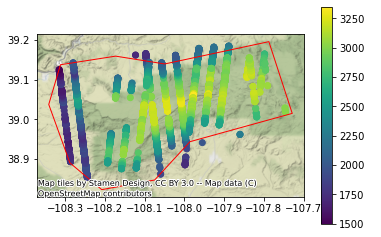

In [30]:
parms = {"poly": grand_mesa,
"srt": icesat2.SRT_LAND,
"cnf": icesat2.CNF_SURFACE_HIGH,
"len": 40.0,
"res": 20,
"maxi": 1,
"t0":'2019-12-10T00:00:00Z',
"t1":'2020-04-12T00:00:00Z'}

rsps = icesat2.atl06p(parms)
rsps = rsps[rsps.h_sigma < 0.1]
rsps = rsps[rsps.n_fit_photons > 200]
rsps['time'] = rsps.index
print(rsps.size)
f, ax = plt.subplots()
rsps.plot(column = 'h_mean', ax = ax, legend = True)
gpd.read_file('grandmesa.geojson').plot(facecolor = "none", edgecolor = 'red', ax = ax)
cx.add_basemap(ax, crs=rsps.crs.to_string())
plt.show()

1029520
0.9691664736907342


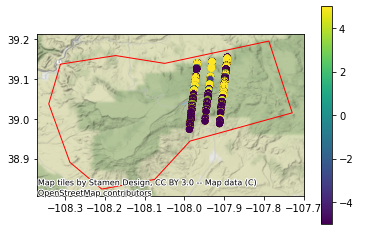

18870
5.330315490263323


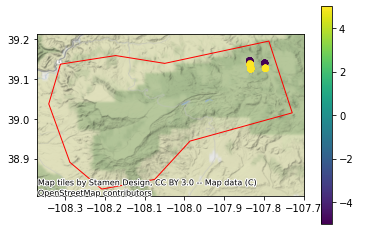

7276
11.910513451041927


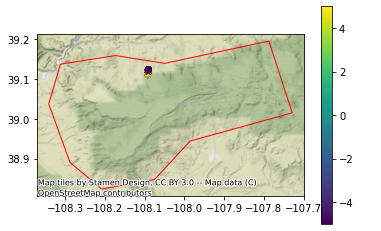

In [31]:
for d in np.unique(rsps.index.date):
    day = rsps[rsps.index.date == d]
    later_days = rsps[rsps.index.date > d]
    for other_date in np.unique(later_days.index.date):
        other_day = later_days[later_days.index.date == other_date]
        # Now reproject to a crs using meters
        day = day.to_crs(epsg = 3857)
        other_day = other_day.to_crs(epsg = 3857)
        # intersect = day.overlay(other_days, how='intersection')
        # Buffer and join
        day['geometry'] = day['geometry'].buffer(200)
        # intersection = gpd.sjoin(day, other_days, how='left')
        intersection = day.overlay(other_day, how='intersection', keep_geom_type=False)
        intersection = intersection.to_crs(rsps.crs)
        intersection['h_delta'] = intersection['h_mean_1'] - intersection['h_mean_2']
        if intersection.size > 0:
            print(intersection.size)
            print(res.h_delta.mean())
            f, ax = plt.subplots()
            intersection.plot(column = 'h_delta', legend = True, ax = ax, vmin = -5, vmax = 5)
            gpd.read_file('grandmesa.geojson').plot(facecolor = "none", edgecolor = 'red', ax = ax)
            cx.add_basemap(ax, crs=intersection.crs.to_string())
            plt.show()
            res = intersection.copy()

In [33]:
res.h_delta

0       2.502015
1      -2.395000
2      -6.442996
3      -0.725524
4      15.657778
         ...    
209    -7.683752
210    -7.598512
211    -6.791375
212    -6.243933
213    -6.622838
Name: h_delta, Length: 214, dtype: float64